In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import scipy
import os

#tf.config.set_visible_devices([], 'GPU') #set tensorflow to use CPU, not enough memory on gpu
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### PARAMETER SETUP

- STATE_DIMENSION - The dimension of the original space.  Treating one complex dimension as two real dimensions
- ANTIKOOPMAN_DIMENSION - The dimension of the reduced space.  Of form (dimension,) to keep tensorflow happy.

In [2]:
STATE_DIMENSION = 4    #Treating two complex dimensions as 4 real dimensions for now
                          #Vector will be [real1, imag1, real2, imag2]
ANTIKOOPMAN_DIMENSION = 2

### DATA GENERATION

Data will be valid states for our quantum system.  For the case of pure states on the Bloch sphere, these are 2 complex dimensional (4 real dimensional) vectors with an L2 norm of 1.

For now, forming state $|\alpha\rangle =\begin{bmatrix}x_1+iy_1\\ x_2+iy_2\end{bmatrix}$ as the row vector $[x_1, y_1, x_2, y_2]$.  Could also try forming as 2x2 matrix $\begin{bmatrix}x_1& y_1\\ x_2& y_2\end{bmatrix}$.  Will likley be flattened when fed to the network though, so there is probably no difference in these methods, just how easy it is to read in the data.

In [3]:
def generate_pure_bloch(batch_size=16):
    '''Generate random pure states on the bloch sphere.
    These are two complex dimensional vectors with an L2 norm of 1.
    Note that the state dimension of the Bloch sphere is always 4.
    '''
    bloch_state_dimension = 4
    while True:
        states = np.empty([batch_size, bloch_state_dimension])
        for i in range(batch_size):
            x1,y1,x2,y2 = np.random.random(4)
            norm = np.sqrt(x1*x1 + y1*y1 + x2*x2 + y2*y2)
            states[i] = 1/norm * np.array([x1,y1, x2,y2])
        yield (states, states) #autoencoder, so data and label are the same thing
        
def generate_one_pure_bloch(batch_size=16):
    '''Same as generate_pure_bloch, but not a generator and only
    returns a single batch for easier testing (?)
    '''
    states = np.empty([batch_size, 4])
    for i in range(batch_size):
        x1,y1,x2,y2 = np.random.random(4)
        norm = np.sqrt(x1*x1 + y1*y1 + x2*x2 + y2*y2)
        states[i] = 1/norm * np.array([x1,y1, x2,y2])
    return (states,states)

In [5]:
initial_state = tf.keras.Input(shape = STATE_DIMENSION)
antikoop_state = tf.keras.Input(shape = ANTIKOOPMAN_DIMENSION)

encoding_layer_1 = tf.keras.layers.Dense(16, activation="relu", name='encoding_layer_1')(initial_state)
encoding_layer_2 = tf.keras.layers.Dense(64, activation="relu", name='encoding_layer_2')(encoding_layer_1)
encoding_layer_3 = tf.keras.layers.Dense(256, activation="relu", name='encoding_layer_3')(encoding_layer_2)
encoding_layer_4 = tf.keras.layers.Dense(64, activation="relu", name='encoding_layer_4')(encoding_layer_3)
encoding_layer_5 = tf.keras.layers.Dense(16, activation="relu", name='encoding_layer_5')(encoding_layer_4)
encoded_state = tf.keras.layers.Dense(ANTIKOOPMAN_DIMENSION, activation="relu", name='bottleneck')(encoding_layer_5)


#Try a U-net architecture? -nvm, won't be able to use U-net once we put the evolution function in
decoding_layer_1 = tf.keras.layers.Dense(16, activation = "relu", name='decoding_layer_1')(antikoop_state)
decoding_layer_2 = tf.keras.layers.Dense(64, activation = "relu", name='decoding_layer_2')(decoding_layer_1)
decoding_layer_3 = tf.keras.layers.Dense(256, activation = "relu", name='decoding_layer_3')(decoding_layer_2)
decoding_layer_4 = tf.keras.layers.Dense(64, activation = "relu", name='decoding_layer_4')(decoding_layer_3)
decoding_layer_5 = tf.keras.layers.Dense(16, activation = "relu", name='decoding_layer_5')(decoding_layer_4)
decoded_state = tf.keras.layers.Dense(STATE_DIMENSION, activation = "relu", name='decoded_layer')(decoding_layer_5)

Phi = tf.keras.Model(inputs=initial_state, outputs = encoded_state, name='Phi')
Phi_inv = tf.keras.Model(inputs = antikoop_state, outputs = decoded_state, name='Phi_inv')

Autoencoder = tf.keras.models.Sequential([Phi, Phi_inv], name='Autoencoder')

In [6]:
def autoencoding_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord = 2)

def learning_scheduler(epoch, lr):
    if epoch < 100:
        lr = .001
    elif epoch < 200:
        lr = .0001
    elif epoch < 300:
        lr = .00005
    else:
        lr = .00005 * tf.math.exp(-0.1)
    return lr
    
learning_schedule = tf.keras.callbacks.LearningRateScheduler(learning_scheduler)


def predict_single_state(state, encoder = Phi, decoder = Phi_inv):
    '''b/c making a prediction for a single element
    is really anoyying in tf/keras
    '''
    encoded = Phi(np.array([state,]))
    decoded = Phi_inv(Phi(np.array([state,])))
    return (state, encoded.numpy(), decoded.numpy())

In [7]:
Autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = .001), loss=autoencoding_loss, metrics = ['mse', 'mae'])

In [8]:
history = Autoencoder.fit(generate_pure_bloch(1024), steps_per_epoch=50,epochs=100)

Epoch 1/100
50/50 [==============================] - 2s 43ms/step - loss: 22.9752 - mse: 0.1325 - mae: 0.2950
Epoch 2/100
50/50 [==============================] - 2s 37ms/step - loss: 20.1014 - mse: 0.0987 - mae: 0.2468
Epoch 3/100
50/50 [==============================] - 3s 51ms/step - loss: 19.9398 - mse: 0.0971 - mae: 0.2416
Epoch 4/100
50/50 [==============================] - 2s 33ms/step - loss: 18.9745 - mse: 0.0879 - mae: 0.2163
Epoch 5/100
50/50 [==============================] - 2s 33ms/step - loss: 18.3639 - mse: 0.0823 - mae: 0.2057
Epoch 6/100
50/50 [==============================] - 2s 41ms/step - loss: 17.8807 - mse: 0.0781 - mae: 0.1955
Epoch 7/100
50/50 [==============================] - 2s 49ms/step - loss: 17.6389 - mse: 0.0760 - mae: 0.1884
Epoch 8/100
50/50 [==============================] - 2s 38ms/step - loss: 16.7963 - mse: 0.0693 - mae: 0.1791
Epoch 9/100
50/50 [==============================] - 2s 43ms/step - loss: 9.9663 - mse: 0.0247 - mae: 0.1191
Epoch 10/10

In [8]:
xt1, yt1, xt2, yt2 = np.random.random(4)
testar = 1/np.sqrt(xt1*xt1 + xt2*xt2 + yt1*yt1 + yt2*yt2) * np.array([xt1,yt1,xt2,yt2])


In [49]:
predict_single_state(testar)

(array([0.38584824, 0.77997634, 0.49100262, 0.04092027]),
 array([[0.779901 , 1.0641254]], dtype=float32),
 array([[0.38071486, 0.77979624, 0.481239  , 0.03151686]], dtype=float32))

In [14]:
from contextlib import redirect_stdout
from datetime import date
def write_history(history, model, loss = 'autoencoding_loss', optimizer='Adam', lr='.001',spe='50',sps='1024'):
    rundatadir = './Autoencoder_Trials/'
    filename = 'test'+str(len(os.listdir(rundatadir)))

    with open(rundatadir+filename+'.data', 'w') as f:
        f.write(str(date.today())+'\n')
        for key in history.history.keys():
            f.write(key+',')
            for epoch in range(history.params['epochs']):
                f.write(str(history.history[key][epoch])+',')
            f.write('\n')
        f.write("Loss:{}\nOptimizer:{}\nLearning Rate:{}\nSteps Per Epoch:{}\nStates Per Step:{}\n".format(loss,optimizer,lr,spe,sps))
        f.write('\n')
        with redirect_stdout(f):
            for i in model:              
                i.summary()
    return rundatadir+filename+'.data'

In [42]:
write_history(history, [Phi, Phi_inv, Autoencoder])

'./Autoencoder_Trials/test9.data'

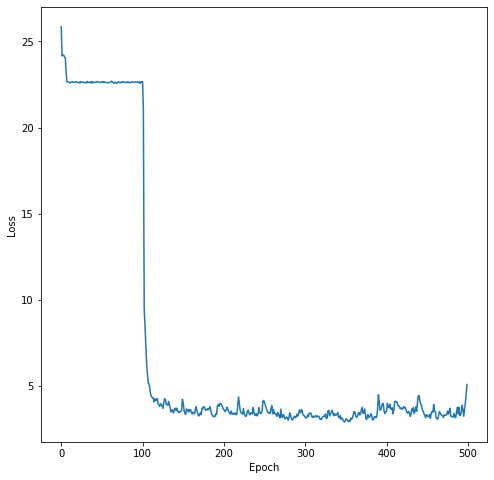

In [43]:
fig, ax = plt.subplots(1,1, figsize = (8,8))


ax.plot(range(history.params['epochs']), history.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

fig.savefig('./Autoencoder_Trials/test5.png')